In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# Challenge: Validating a linear regression
In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include [other states crime rates in 2013](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table_8_offenses_known_to_law_enforcement_by_state_by_city_2013.xls/view) or [crime rates in New York State in other years](https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls) or a combination of these.

# Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

In [0]:
crime_path ='https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
crime_data = pd.read_csv(crime_path, skiprows=4, skipfooter=3, engine='python')

In [0]:
def convert_number(number):
    try:
        converted = float(number.replace(',', ''))
    except:
        converted = number
    
    return converted

In [237]:
crime_data.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [0]:
crime_data.columns = ['city', 'population', 'violent_crime', 'murder_manslaughter', 
'rape', 'robbery', 'assault', 'property_crime', 'burglary', 'larceny_theft', 
'vehicle_theft', 'arson', 'murder']

crime_data.fillna(0)
crime_data['population'] = crime_data['population'].apply(lambda x: convert_number(x))
crime_data['murder_manslaughter'] = crime_data['murder_manslaughter'].apply(lambda x: convert_number(x))
crime_data['robbery'] = crime_data['robbery'].apply(lambda x: convert_number(x))
crime_data['property_crime'] = crime_data['property_crime'].apply(lambda x: convert_number(x))
crime_data['larceny_theft'] = crime_data['larceny_theft'].apply(lambda x: convert_number(x))

In [239]:
crime_data.describe()

,population,murder_manslaughter,rape,robbery,property_crime,larceny_theft,murder
count,348.000,348.000,0.000,348.000,348.000,348.000,187.000
mean,40037.632,1.566,nan,5.865,121.261,119.684,1.872
std,450037.368,18.304,nan,60.425,1706.132,924.949,10.693
min,526.000,0.000,nan,0.000,0.000,0.000,0.000
25%,3003.000,0.000,nan,0.000,1.000,6.000,0.000
50%,7233.500,0.000,nan,0.000,4.000,17.500,0.000
75%,18427.500,0.000,nan,2.000,14.000,51.250,1.000
max,8396126.000,335.000,nan,1112.000,31767.000,16606.000,132.000


In [0]:
crime_data = crime_data.drop('rape', 1)

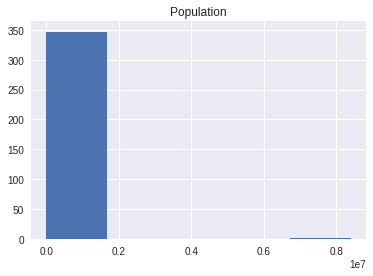

In [241]:
crime_data['population'].hist(bins=5)
plt.title('Population')
plt.show()

median = crime_data.population.median()
std = crime_data.population.std()
pop_ends = median + 2* std

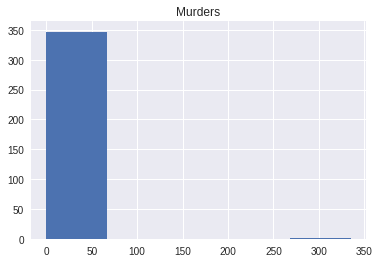

In [242]:
crime_data['murder_manslaughter'].hist(bins=5)
plt.title('Murders')
plt.show()

median = crime_data['murder_manslaughter'].median()
std = crime_data['murder_manslaughter'].std()
mur_ends = median + 2* std

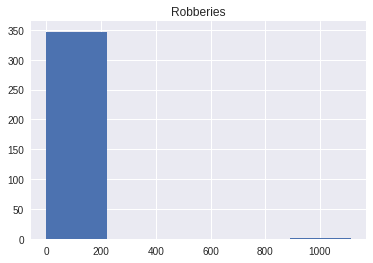

In [243]:
crime_data['robbery'].hist(bins=5)
plt.title('Robberies')
plt.show()

median = crime_data.robbery.median()
std = crime_data.robbery.std()
rob_ends = median + 2* std

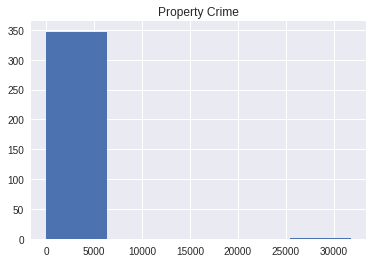

In [244]:
crime_data['property_crime'].hist(bins=5)
plt.title('Property Crime')
plt.show()

median = crime_data['property_crime'].median()
std = crime_data['property_crime'].std()
prop_ends = median + 2* std

In [0]:
crime_data['population'] = crime_data.population.map(lambda x: x if x < pop_ends else None)
crime_data['murder_manslaughter'] = crime_data['murder_manslaughter'].map(lambda x: x if x < mur_ends else None)
crime_data['robbery'] = crime_data.robbery.map(lambda x: x if x < rob_ends else None)
crime_data['property_crime'] = crime_data['property_crime'].map(lambda x: x if x < prop_ends else None)

In [0]:
crime_data['popSq'] = crime_data['population']**2

In [0]:
def convert_category(number):
    value = convert_number(number)
    
    if value>0:
        return 1
    else:
        return 0

In [248]:
crime_data['murder_categorical'] = crime_data['murder_manslaughter'].apply(lambda x: convert_category(x))
crime_data['robbery_categorical'] = crime_data['robbery'].apply(lambda x: convert_category(x))
crime_data.head()

,city,population,violent_crime,murder_manslaughter,robbery,assault,property_crime,burglary,larceny_theft,vehicle_theft,arson,murder,popSq,murder_categorical,robbery_categorical
0,Adams Village,1861.000,0,0.000,0.000,0,0.000,12,2.000,10,0,0.000,3463321.000,0,0
1,Addison Town and Village,2577.000,3,0.000,0.000,0,3.000,24,3.000,20,1,0.000,6640929.000,0,0
2,Akron Village,2846.000,3,0.000,0.000,0,3.000,16,1.000,15,0,0.000,8099716.000,0,0
3,Albany,97956.000,791,8.000,30.000,227,526.000,"4,090",705.000,"3,243",142,nan,9595377936.000,1,1
4,Albion Village,6388.000,23,0.000,3.000,4,16.000,223,53.000,165,5,nan,40806544.000,0,1


In [249]:
features = crime_data[['population', 'popSq', 'murder_categorical', 'robbery_categorical', 'property_crime']].dropna()
features.head()

,population,popSq,murder_categorical,robbery_categorical,property_crime
0,1861.000,3463321.000,0,0,0.000
1,2577.000,6640929.000,0,0,3.000
2,2846.000,8099716.000,0,0,3.000
3,97956.000,9595377936.000,1,1,526.000
4,6388.000,40806544.000,0,1,16.000


In [250]:
regr = linear_model.LinearRegression()
Y = features['property_crime']
X = features[['population', 'popSq', 'murder_categorical', 'robbery_categorical']]

regr.fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n')
print(regr.score(X, Y))


Coefficients: 
 [-4.69223576e-04  2.51858430e-08  4.01799612e+01  1.00699455e+01]

Intercept: 
 3.274131954874427

R-squared: 

0.8681606031657333


Here we calculate the error and residual.

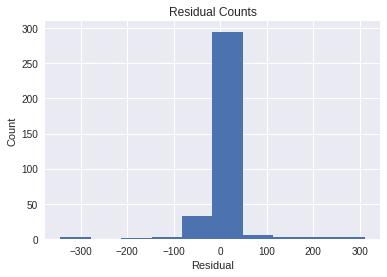

In [251]:
predicted = regr.predict(X).ravel()
actual = features['property_crime']

residual = actual - predicted

plt.hist(residual)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Counts')
plt.show()

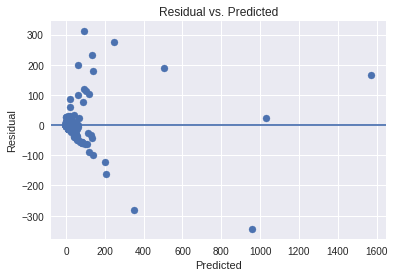

In [252]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

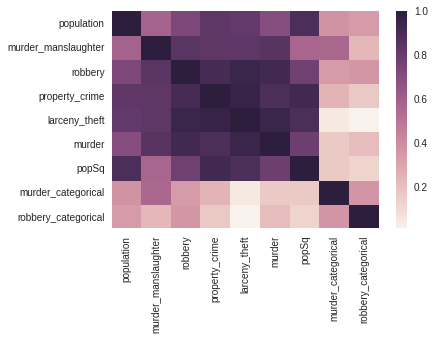

In [253]:
sns.heatmap(crime_data.corr())

In [254]:
X_data = X
X_data.head(5)

,population,popSq,murder_categorical,robbery_categorical
0,1861.000,3463321.000,0,0
1,2577.000,6640929.000,0,0
2,2846.000,8099716.000,0,0
3,97956.000,9595377936.000,1,1
4,6388.000,40806544.000,0,1


In [255]:
Y_target = Y
Y_target.head(5)

0     0.000
1     3.000
2     3.000
3   526.000
4    16.000
Name: property_crime, dtype: float64

In [256]:
X.describe()

,population,popSq,murder_categorical,robbery_categorical
count,347.000,347.000,347.000,347.000
mean,15956.686,985840709.758,0.133,0.409
std,27080.219,5067232380.434,0.340,0.492
min,526.000,276676.000,0.000,0.000
25%,2997.000,8982153.000,0.000,0.000
50%,7187.000,51652969.000,0.000,0.000
75%,18160.500,329804222.500,0.000,1.000
max,258789.000,66971746521.000,1.000,1.000


In [0]:
Xdf = X
Ydf = Y

from sklearn.model_selection import KFold
X = Xdf.values
y = Ydf.values

In [0]:
#We add a min max scaler before fitting the regression models

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## K-fold cross validation

We shuffle the data and split it into 10 training and test folds. We evaluate the mean r square value of all the folds.  

In [269]:
# We set
kf = KFold(n_splits=10, random_state=1, shuffle=True)
kf.get_n_splits(X)

print(kf)

r2_scores=[]

for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  regr.fit(X_train, y_train)
  r2_scores.append(regr.score(X_test, y_test))
  
  
r2_scores


KFold(n_splits=10, random_state=1, shuffle=True)


[0.2822096581989495,
 0.6021483459504344,
 -2.7675584751566498,
 0.9917436263637852,
 0.8952611375316926,
 -0.20866147978041671,
 0.7426238422086836,
 0.38117343296103584,
 0.5511432988516207,
 -0.5035370090523554]

The mean $r^2$ value after 10 fold cross validation

In [270]:
np.mean(r2_scores)

0.096654637807678

## Discussion on the significance of low r square values in the social sciences

+ https://www.researchgate.net/post/Low_R-squared_values_in_multiple_regression_analysis
+ https://www.researchgate.net/post/what_is_the_acceptable_r-squared_value